In [1]:
import os

# Preview Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Preprocessing Data

import os
import numpy as np
import cv2

# Model Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Accuracy and Loss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
picture = 'Data'
classes_picture = os.listdir(picture)
print("Classes in this dataset are:")
for i in classes_picture:
    print(i)





Classes in this dataset are:
Adams
Jeremy
Samuel



Adams
Total Images: 101
Resolution of The Image: (1280, 960, 3)


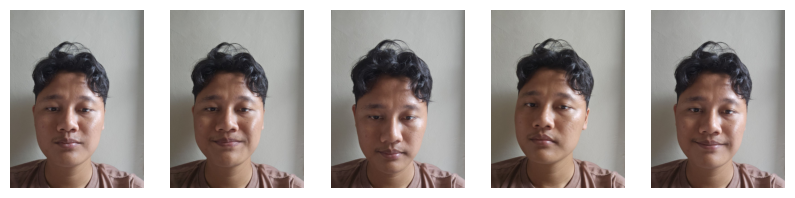


Jeremy
Total Images: 100
Resolution of The Image: (4352, 3264, 3)


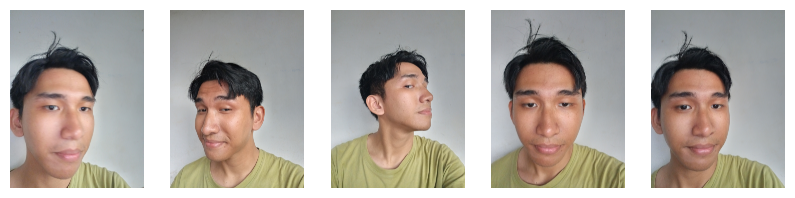


Samuel
Total Images: 101
Resolution of The Image: (4080, 3072, 3)


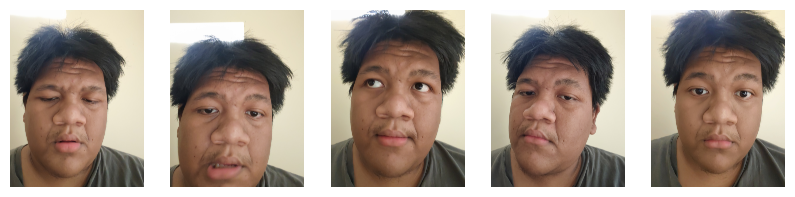

In [3]:
for item in classes_picture:
  print("")
  print(item)
  class_dir = os.path.join(picture, item)
  class_images = os.listdir(class_dir)
  random.shuffle(class_images)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of The Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

Processing Adams...
Processing Jeremy...
Processing Samuel...

Resized data shape: (302, 224, 224, 3)
Labels shape: (302,)


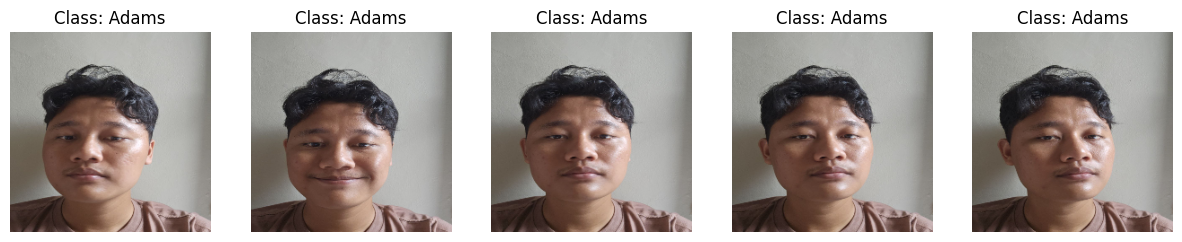

In [4]:
# Define the target size for resizing images
target_size = (224, 224)

# Create lists to store resized images and their labels
X = []  # Images
y = []  # Labels

# Process each class
for class_idx, class_name in enumerate(classes_picture):
    class_dir = os.path.join(picture, class_name)
    class_images = os.listdir(class_dir)
    
    print(f"Processing {class_name}...")
    
    # Process each image in the class
    for img_name in class_images:
        img_path = os.path.join(class_dir, img_name)
        try:
            # Read and resize image
            img = mpimg.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            
            # Append resized image and its label
            X.append(img_resized)
            y.append(class_idx)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("\nResized data shape:", X.shape)
print("Labels shape:", y.shape)

# Display some resized images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Class: {classes_picture[y[i]]}")
    plt.axis('off')
plt.show()


In [5]:
# Split data into train (70%), validation (20%), and test (10%)
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: split temp into 20% val and 10% test (20/30 ≈ 0.67 of temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples") 
print(f"Test set: {len(X_test)} samples")


Train set: 211 samples
Validation set: 60 samples
Test set: 31 samples


In [46]:

# Define data augmentation parameters with maximum aggressive augmentation for extreme variance
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,  # Maximum rotation range
    width_shift_range=0.5,  # Maximum width shift
    height_shift_range=0.5,  # Maximum height shift
    zoom_range=0.6,  # Maximum zoom range
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.3, 2.0],  # Extreme brightness variation
    shear_range=0.4,  # Add shear transformation
    channel_shift_range=50.0,  # Add color channel shifting
    fill_mode='reflect'  # Use reflect mode for more variety
)

# Create a generator for training data with very small batch size for maximum variance
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=8,  # Very small batch size for maximum variance
    shuffle=True  # Ensure shuffling for more randomness
)

# Create a generator for validation data (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=8,  # Match batch size
)

# Create a generator for test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=8,  # Match batch size
    shuffle=False
)


In [47]:
model_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model_base.layers:
    layer.trainable = False


model = tf.keras.Sequential([
    model_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,267 (10.02 MB)

 Trainable params: 369,283 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
# Compile the model with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Changed from binary_crossentropy
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


c:\Users\Swift GO 14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - accuracy: 0.5608 - loss: 0.9103 - val_accuracy: 0.9333 - val_loss: 0.3864
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.8591 - loss: 0.3480 - val_accuracy: 0.9667 - val_loss: 0.1936
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.8273 - loss: 0.4881 - val_accuracy: 0.9667 - val_loss: 0.1678
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9575 - loss: 0.1312 - val_accuracy: 0.9667 - val_loss: 0.1078
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.8923 - loss: 0.3954 - val_accuracy: 0.9833 - val_loss: 0.0889
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 612ms/step - accuracy: 0.9396 - loss: 0.1700 - val_accuracy: 0.9333 - val_loss: 0.1566
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 649ms/step - accuracy: 0.9344 - loss: 0.1778 - val_accuracy: 1.0000 - val_loss: 0.0685
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9383 - loss: 0.1858 - val_accuracy: 0

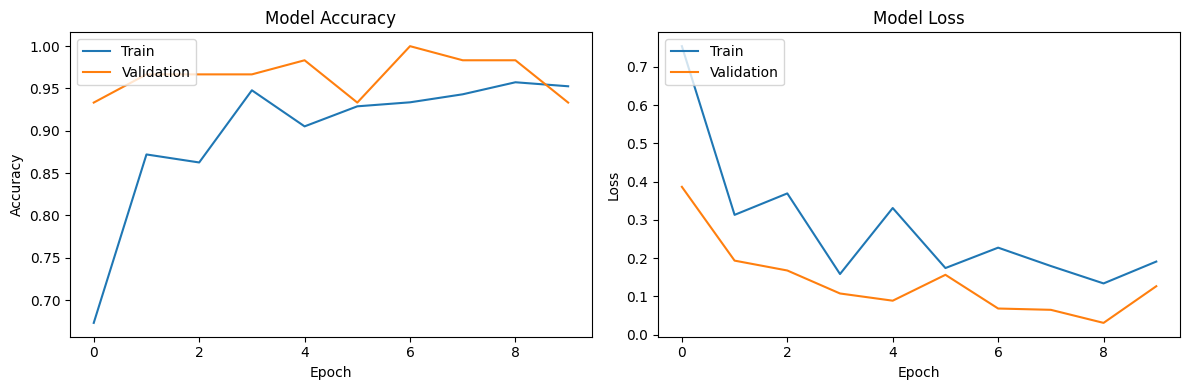

In [50]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [62]:
# Evaluate the model on the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        10

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31



In [63]:
# Print the final test accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9413 - loss: 0.0984
Test Accuracy: 0.9677


In [64]:
model.save('model.h5')